# Monte Carlo Rocket Simulations

Like in the simple rocket we'll generate a parametric rocket and simulate it's flight. Only this time we'll do it over and over again with randomly generated parameters.

In [1]:
import random
from math import pi
import os
import subprocess
import time
from openrocketdoc import document
from openrocketdoc import writers

# Fixed parameters:
prop_density = 1750  # kg/m3  Roughtly HTPB composite solid density[1]
LD           =   10  # Motor length to width ratio
Nose_LD      =    5  # Nosecone length to width ratio


def run_once(run_num):
    """Runs one simlation"""
    
    #######################################################################
    # Random variables!!
    
    # Isp: Radomly centered on nominal value on 200 s
    Isp = random.gauss(200, 20)
    
    # Average Thrust: Randomly centered on nominal value of 2 kN
    thrust_avg = random.gauss(2000, 200)
    
    # Total impulse, Randomly centered on nominal value of 15000 N*s
    I_total = random.gauss(15000, 1000)
    
    # Drag estimate: Random in wide range
    CD = random.uniform(0.45, 0.8)
    #######################################################################
    
    
    # Create an engine document
    engine = document.Engine('Motor')

    # Set our design
    engine.Isp = Isp
    engine.thrust_avg = thrust_avg
    engine.I_total = I_total
    
    # volume of propellent needed
    prop_volume = engine.m_prop/prop_density

    # Solve for the radius/length of the fuel grain (assume solid, end burning)
    engine.diameter = 2*(prop_volume/ (2*LD*pi))**(1/3.0)
    engine.length = engine.diameter * LD

    # Add a nose
    nose = document.Nosecone(
        document.Noseshape.TANGENT_OGIVE,  # Shape
        1.0, # shape_parameter
        1.5, # mass
        engine.diameter * Nose_LD,
        diameter=engine.diameter,
        material_name="Aluminium"
    )

    # Payload section
    payload = document.Bodytube(
        "Payload",  # Name
        2.5,        # mass
        0.33,       # length
        diameter=engine.diameter,
        material_name="Aluminium"
    )

    # Body section the size of the engine
    body = document.Bodytube(
        "Body",  # Name
        1.5,     # mass
        engine.length,
        diameter=engine.diameter,
        material_name="Aluminium"
    )

    body.components = [engine]

    # Rocket:
    rocket = document.Rocket("Rocket")
    rocket.aero_properties['CD'] = [CD]
    stage0 = document.Stage("Sustainer")
    stage0.components = [nose, payload, body]
    rocket.stages = [stage0]
    
    aircraft_path = os.path.join("aircraft", rocket.name_slug)
    engine_path = "engine"

    if not os.path.exists(aircraft_path):
        os.makedirs(aircraft_path)
    if not os.path.exists(engine_path):
        os.makedirs(engine_path)

    aircraft_filename = rocket.name_slug + '.xml'
    with open(os.path.join(aircraft_path, aircraft_filename), 'w') as outfile:
        outfile.write(writers.JSBSimAircraft.dump(rocket))

    engine_filename = engine.name_slug + '.xml'
    with open(os.path.join(engine_path, engine_filename), 'w') as outfile:
        outfile.write(writers.JSBSimEngine.dump(engine))

    nozzle_filename = engine.name_slug + '_nozzle.xml'
    with open(os.path.join(engine_path, nozzle_filename), 'w') as outfile:
        outfile.write("""<?xml version="1.0"?>
    <nozzle name="Nozzle">
      <area unit="M2"> 0.001 </area>
    </nozzle>
    """)
        
    with open("output_file.xml", 'w') as outfile:
        outfile.write("""<?xml version="1.0" encoding="utf-8"?>
<output name="data-%03d.csv" type="CSV" rate="10">
  <property caption="Altitude MSL [m]">     position/h-sl-meters            </property>
  <property caption="Thrust [lbf]">         forces/fbx-prop-lbs             </property>
  <property caption="Total Weight [lbs]">   inertia/weight-lbs              </property>
  <property caption="ECEF Vel. Down [fps]"> velocities/v-down-fps           </property>
</output>""" % run_num)
    
    # Trigger JSBSim
    p = subprocess.Popen(["JSBSim", "--logdirectivefile=output_file.xml", "--script=run.xml"])
    time.sleep(3) # let it run

In [2]:
# Run 200 times
for i in range(200):
    run_once(i)

In [44]:
# Chart
import csv
import statistics
import matplotlib.pyplot as plt
%matplotlib inline

FPS2M = 0.3048
LBF2N = 4.44822
LBS2KG = 0.453592

max_alt = 0
max_alt_time = 0
max_alts = []
sim_times = []
sim_vel_ups = []
sim_alts = []
for i in range(200):
    # Read data from JSBSim
    sim_time = []
    sim_vel_up = []
    sim_alt = []
    this_max_alt = 0
    with open("data-%03d.csv" % i) as datafile:
        reader = csv.reader(datafile, delimiter=',')
        for row in reader:
            # ignore first line
            if row[0][0] == 'T':
                continue
            time      = float(row[0])           # s
            alt       = float(row[1])           # m
            thrust    = float(row[2]) * LBF2N   # N
            weight    = float(row[3]) * LBS2KG  # kg
            vel_down  = float(row[4]) * FPS2M   # m/s

            sim_time.append(time)
            sim_vel_up.append(-vel_down)
            sim_alt.append(alt)

            # max alt
            if alt > max_alt:
                max_alt = alt
                max_alt_time = time
            if alt > this_max_alt:
                this_max_alt = alt
    max_alts.append((i, this_max_alt))
    sim_times.append(sim_time)
    sim_vel_ups.append(sim_vel_up)
    sim_alts.append(sim_alt)

sorted_max = sorted(max_alts, key=lambda tup: tup[1])
mlist = [tup[1] for tup in sorted_max]

print("Highest sim went to:         %5.1f km" % (mlist[-1] / 1000.0))
print("Lowest sim went to:          %5.1f km" % (mlist[0] / 1000.0))

mean = statistics.mean(mlist)
median = statistics.median(mlist)
print("The mean sim altitude was:   %5.1f km" % (mean / 1000.0))
print("The median sim altitude was: %5.1f km" % (median / 1000.0))

Highest sim went to:          17.8 km
Lowest sim went to:            8.0 km
The mean sim altitude was:    11.6 km
The median sim altitude was:  11.3 km


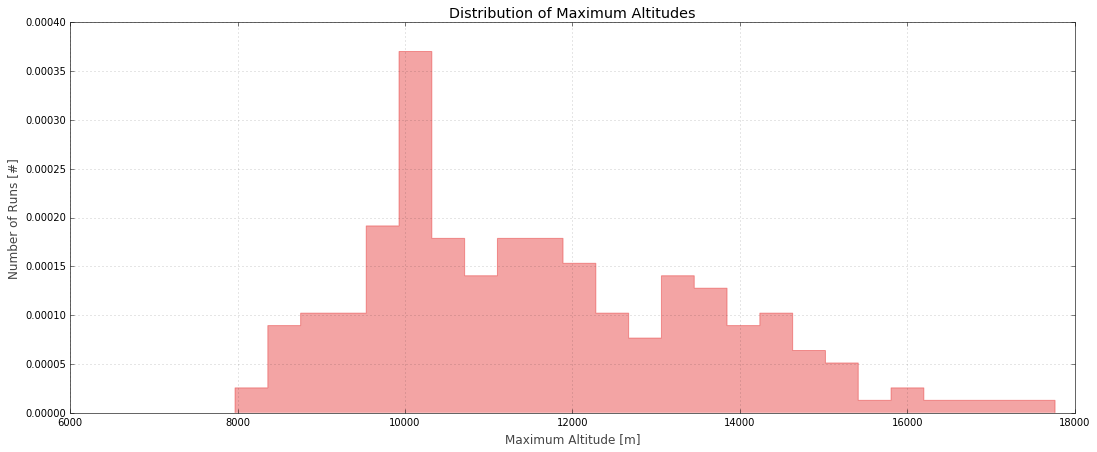

In [45]:
fig, ax1 = plt.subplots(figsize=(18,7))
plt.title(r"Distribution of Maximum Altitudes")
plt.ylabel(r"Number of Runs [#]")
plt.xlabel(r"Maximum Altitude [m]")

n, bins, patches = plt.hist(mlist, 25, histtype='step', normed=1, alpha=0.4, linewidth=1, fill=True)

#plt.ylim([0, 35])
#plt.xlim()
plt.show()

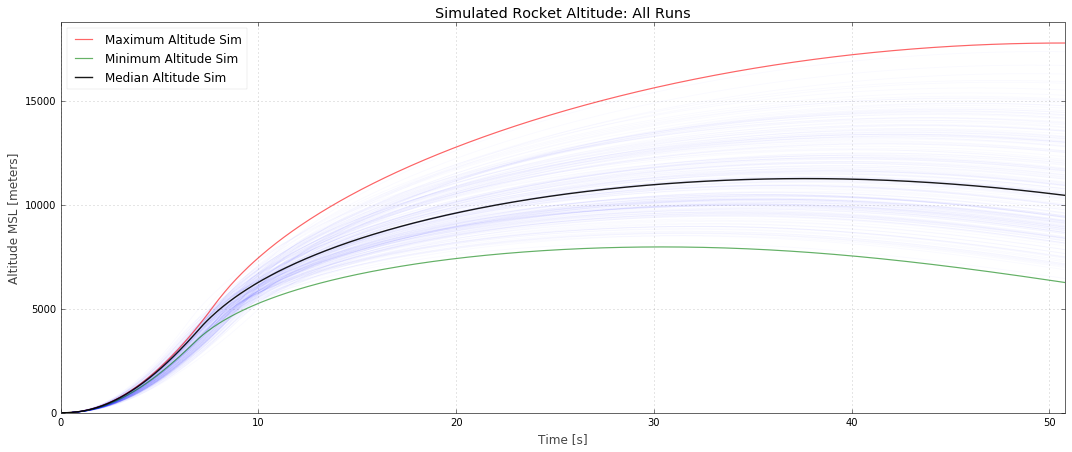

In [46]:
fig, ax1 = plt.subplots(figsize=(18,7))
plt.title(r"Simulated Rocket Altitude: All Runs")
plt.ylabel(r"Altitude MSL [meters]")
plt.xlabel(r"Time [s]")
    
for i in range(len(max_alts)):
    plt.plot(sim_times[i], sim_alts[i], 'b-', lw=1.0, alpha=0.02)

max_i = sorted_max[-1][0]
plt.plot(sim_times[max_i], sim_alts[max_i], 'r-', lw=1.2, alpha=0.6, label="Maximum Altitude Sim")
min_i = sorted_max[0][0]
plt.plot(sim_times[min_i], sim_alts[min_i], 'g-', lw=1.2, alpha=0.6, label="Minimum Altitude Sim")
median_i = min(sorted_max, key=lambda tup: abs(tup[1]-median))
plt.plot(sim_times[median_i[0]], sim_alts[median_i[0]], 'k-', lw=1.4, alpha=0.9, label="Median Altitude Sim")

plt.ylim([0, max_alt + 1000])
plt.xlim([0, max_alt_time])
plt.legend(loc=2)
plt.show()